# Titanic algoritmo XGBOOST

# Carga de librerías:

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

import xgboost as xgb
plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Definición de funciones:

In [34]:
def relaciones_vs_target(X, Y, return_type='axes'):
    '''
    Función que representa gráficos de dispersión de las variables
    en X en función a la variable Y
    '''
    fig_tot = (len(X.columns))
    fig_por_fila = 4
    tamanio_fig = 4
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', 
                          label_0='Clase 0', density=0):
    '''
    Función que recibe dos distribuciones de probabilidad y las representa
    en el mismo gráfico
    '''
    bins = n_bins
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best') 

def hist_pos_neg_feat(x, y, density=0, nbins=11, targets=(0,1)):
    '''
    Representa las variables en x divididas en dos distribuciones
    según su valor de y sea 1 o 0
    '''
    fig_tot = len(x.columns)
    fig_tot_fila = 4; fig_tamanio = 4
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins, 
                   density = density, title=('%s' % feat))

# Inputs

In [1]:
# Defino la lista de nombres de las variables

#XY_train = pd.read_csv('C:/Users/aitor/OneDrive/Escritorio/Anaconda/input/titanic/train.csv', sep=',')
#XY_test = pd.read_csv('C:/Users/aitor/OneDrive/Escritorio/Anaconda/input/titanic/test.csv', sep=',')

NameError: name 'pd' is not defined

In [2]:
#MAC

XY_train = pd.read_csv('/Users/aitorelordizamora/Documents/input/train.csv', sep=',')
XY_test = pd.read_csv('/Users/aitorelordizamora/Documents/input/test.csv', sep=',')

In [6]:
XY_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
print(u'- El número de filas en el dataset es: {}'.format(XY_train.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY_train.shape[1]))
print(u'- Los nombres de las variables son: {}'.format(list(XY_train.columns)))

- El número de filas en el dataset es: 891
- El número de columnas en el dataset es: 12
- Los nombres de las variables son: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


# Preprocesamiento de datos

# Missings:

In [11]:
XY_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
XY_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

La elección del método de imputación depende de la naturaleza de los datos y la distribución de la variable. En general, la media se utiliza para variables numéricas continuas, mientras que la moda se utiliza para variables categóricas o discretas. Sin embargo, existen otros métodos de imputación que también se pueden utilizar según las características de los datos, como la mediana o modelos predictivos.

In [13]:
mean = XY_train['Age'].mean()
XY_train['Age'].fillna(mean, inplace=True)

moda = XY_train['Embarked'].mode()
XY_train['Embarked'].fillna(moda, inplace=True)

XY_train.Age = XY_train.Age.astype(int)
XY_train.Fare = XY_train.Fare.astype(int)

XY_train["CabinB"] = XY_train["Cabin"].notnull().astype(int)


mean = XY_test['Fare'].mean()
XY_test['Fare'].fillna(mean, inplace=True)

mean2 = XY_test['Age'].mean()
XY_test['Age'].fillna(mean2, inplace=True)

XY_test["CabinB"] = XY_test["Cabin"].notnull().astype(int)

XY_test.Age = XY_test.Age.astype(int)
XY_test.Fare = XY_test.Fare.astype(int)

In [15]:
le = LabelEncoder()

In [16]:
XY_train.Pclass = le.fit_transform(XY_train.Pclass)
XY_train.Sex = le.fit_transform(XY_train.Sex)
XY_train.Embarked = le.fit_transform(XY_train.Embarked)


XY_test.Pclass = le.fit_transform(XY_test.Pclass)
XY_test.Sex = le.fit_transform(XY_test.Sex)
XY_test.Embarked = le.fit_transform(XY_test.Embarked)



In [18]:
del XY_train['Name']
del XY_train['Ticket']
del XY_train['Cabin']
del XY_train['PassengerId']

del XY_test['Name']
del XY_test['Ticket']
del XY_test['Cabin']



# Comprobación tipos no numéricos:

In [19]:
XY_train.select_dtypes(exclude=['number']).columns

Index([], dtype='object')

# Division en features X + target Y

In [20]:
X = XY_train.drop('Survived', axis=1)
Y = XY_train['Survived']

# Boxplots:

In [21]:
X_normalizado = (X-X.mean())/X.std()

In [22]:
X_normalizado[:2]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinB
0,0.826913,0.737281,-0.579719,0.43255,-0.473408,-0.498667,0.580788,-0.544619
1,-1.565228,-1.354813,0.649747,0.43255,-0.473408,0.788962,-1.937372,1.834085


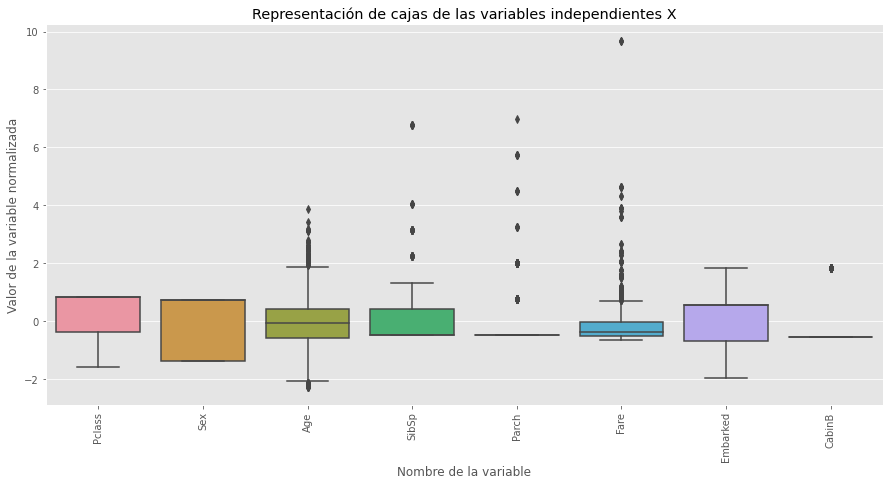

In [25]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

# Histogramas:

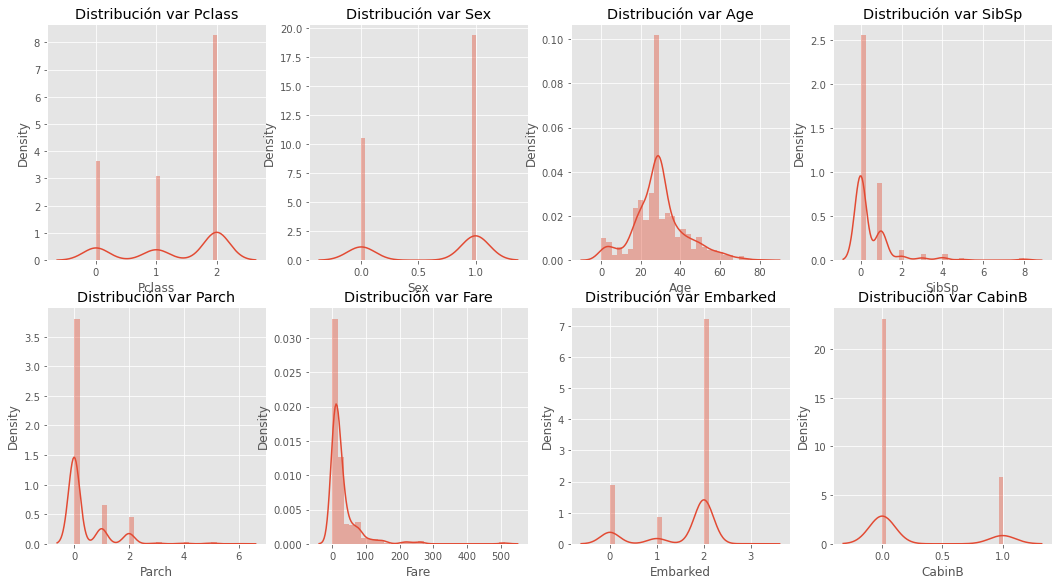

In [28]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(X.columns):
    n+=1
    plt.subplot(4, 4, n)
    sns.distplot(X[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

# Relación variable vs target:

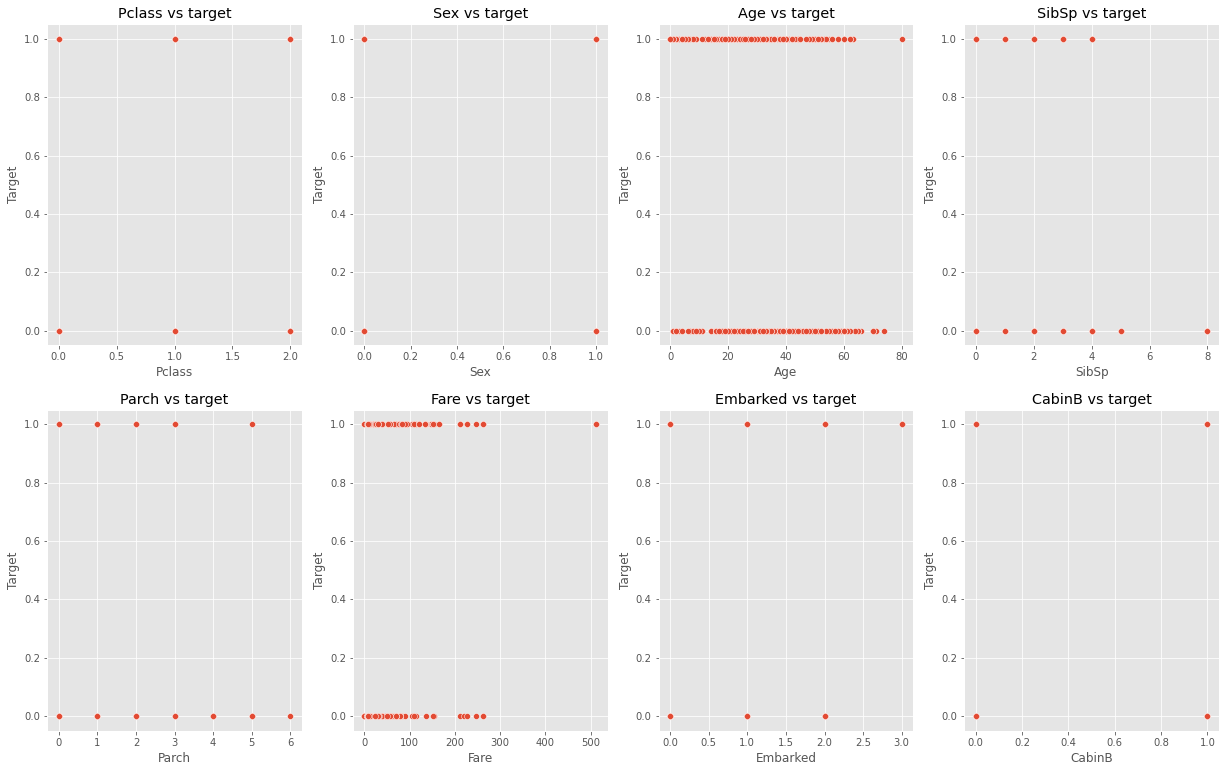

In [32]:
relaciones_vs_target(X, Y)

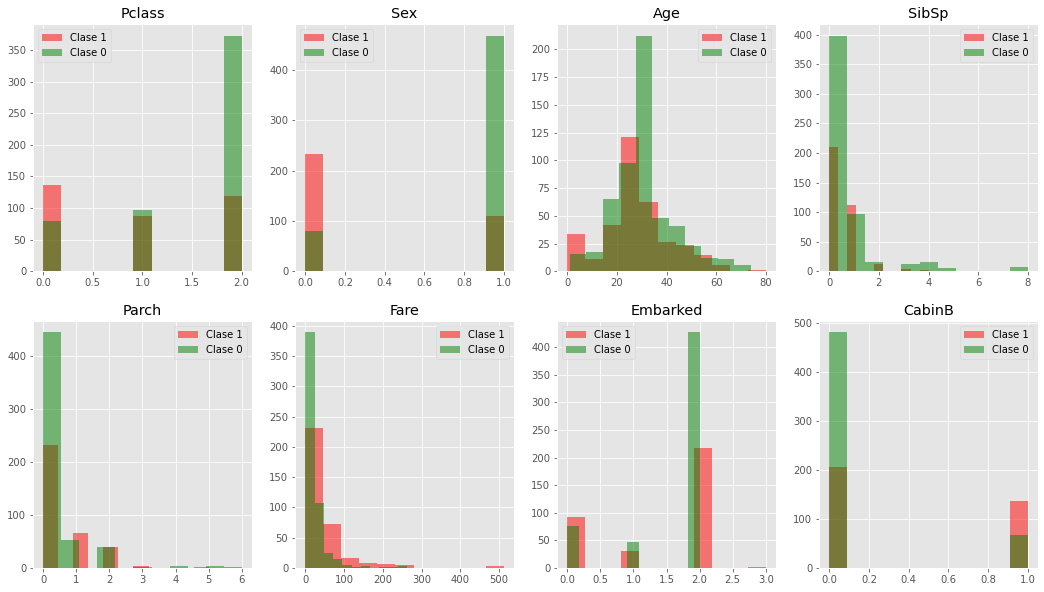

In [35]:
hist_pos_neg_feat(X,Y)

Estos gráficos son interesantes para analizar el poder predictivo de las variables. Cuanto más se separen las dos distribuciones, mejor para predecir ya que es más fácil discriminarlas.

# Matriz de correlaciones:

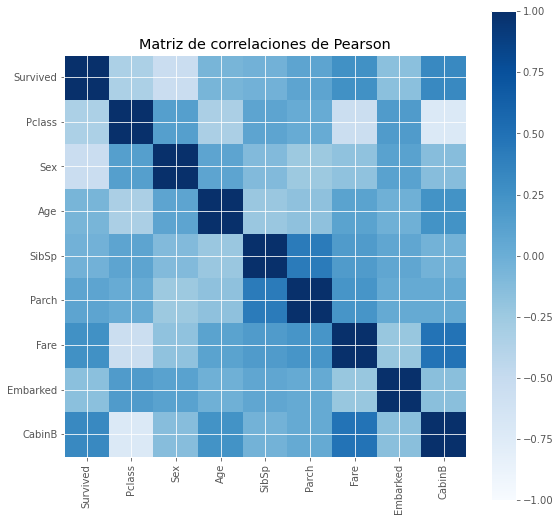

In [36]:
matriz_correlaciones = XY_train.corr(method='pearson')
n_ticks = len(XY_train.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY_train.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY_train.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

# Variables con mayor correlación con la target:

In [37]:
correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
Sex,-0.725541
Embarked,0.482219
Pclass,0.316912
SibSp,0.236172
CabinB,-0.154457
Age,-0.140391
Parch,-0.040460
Fare,0.036987


# División en train y test:

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [43]:
# Crear el modelo de XGBoost
model = xgb.XGBClassifier()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión: %.2f%%" % (accuracy * 100.0))

Precisión: 82.12%


In [46]:
# Definir los parámetros del modelo de XGBoost con regularización LASSO
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 5,
    'reg_alpha': 0.1,
    'booster': 'gbtree',
    'n_jobs': -1,
    'random_state': 42
}

# Crear el modelo de XGBoost con regularización LASSO
model = xgb.XGBClassifier(**params)

# Entrenar el modelo con regularización LASSO
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])

# Realizar predicciones en el conjunto de prueba con el modelo ajustado
y_pred = model.predict(X_test)

# Calcular la precisión del modelo ajustado
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo ajustado: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-logloss:0.64901
[1]	validation_0-logloss:0.61331
[2]	validation_0-logloss:0.58423
[3]	validation_0-logloss:0.56003
[4]	validation_0-logloss:0.53882
[5]	validation_0-logloss:0.52100
[6]	validation_0-logloss:0.50758
[7]	validation_0-logloss:0.49624
[8]	validation_0-logloss:0.48616
[9]	validation_0-logloss:0.47876
[10]	validation_0-logloss:0.47130
[11]	validation_0-logloss:0.46323
[12]	validation_0-logloss:0.45767
[13]	validation_0-logloss:0.45434
[14]	validation_0-logloss:0.45042
[15]	validation_0-logloss:0.44485
[16]	validation_0-logloss:0.44314
[17]	validation_0-logloss:0.44121
[18]	validation_0-logloss:0.43810
[19]	validation_0-logloss:0.43605
[20]	validation_0-logloss:0.43470
[21]	validation_0-logloss:0.43349
[22]	validation_0-logloss:0.43296
[23]	validation_0-logloss:0.43197
[24]	validation_0-logloss:0.43194
[25]	validation_0-logloss:0.43211
[26]	validation_0-logloss:0.43117
[27]	validation_0-logloss:0.43200
[28]	validation_0-logloss:0.43236
[29]	validation_0-loglos

En este ejemplo, se crea un modelo de regresión logística LASSO y se utiliza el parámetro reg_alpha para especificar el parámetro de regularización para el modelo de XGBoost. Se define un conjunto de valores para los parámetros de XGBoost y se entrena el modelo utilizando early_stopping_rounds para evitar el sobreajuste. Luego, se utilizan las predicciones para calcular la precisión del modelo en el conjunto de prueba. La regularización LASSO ayuda a evitar el sobreajuste al penalizar los coeficientes de las variables menos importantes, reduciendo la complejidad del modelo.






In [47]:
# crea objetos DMatrix para tus datos de entrenamiento y prueba
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# define los parámetros que deseas utilizar para tu modelo XGBoost
params = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 1000
}

# llama a la función cv() de xgboost con los parámetros y los objetos DMatrix
cv_results = xgb.cv(params=params, dtrain=dtrain, num_boost_round=10, nfold=5, metrics=['logloss'], early_stopping_rounds=10, seed=42)

# muestra los resultados de la validación cruzada
print(cv_results)

[23:27:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[23:27:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[23:27:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[23:27:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[23:27:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

   train-logloss-mean  train-logloss-std  test-logloss-mean  test-logl

Los resultados que se muestran son los valores medios (mean) y las desviaciones estándar (std) de la función de pérdida (logloss) en el conjunto de entrenamiento (train) y en el conjunto de validación (test) a medida que aumenta el número de iteraciones del modelo.

Podemos usar estos resultados para evaluar el rendimiento del modelo. En este caso, podemos ver que la función de pérdida disminuye tanto en el conjunto de entrenamiento como en el de validación a medida que aumenta el número de iteraciones, lo que indica que el modelo está mejorando.

Además, podemos observar que la desviación estándar de la función de pérdida es muy baja, lo que sugiere que el modelo está generalizando bien a datos nuevos. Sin embargo, para obtener una evaluación más completa del modelo, se debe evaluar su rendimiento en un conjunto de datos de prueba independiente.

In [48]:
params = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7]
}

# Crear el modelo de XGBoost
model = xgb.XGBClassifier()

# Utilizar GridSearchCV para encontrar los mejores parámetros del modelo
grid_search = GridSearchCV(model, params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados por GridSearchCV
print("Mejores parámetros: ", grid_search.best_params_)

# Realizar predicciones en el conjunto de prueba con el modelo ajustado
y_pred = grid_search.predict(X_test)

# Calcular la precisión del modelo ajustado
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo ajustado: %.2f%%" % (accuracy * 100.0))



Mejores parámetros:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Precisión del modelo ajustado: 82.68%


# Predicción

In [49]:
#Realizo la prediccion para los datos test
ids = XY_test['PassengerId']
predictions = grid_search.predict(XY_test.drop('PassengerId', axis=1))


output = pd.DataFrame({
    'PassengerId': ids,
    'Survived' : predictions
})

output.to_csv('submission.csv', index=False)

In [50]:
display(output)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
